In [ ]:
# default_exp timeseries.core

In [ ]:
#hide
#export
import pandas as pd
from fastai.data.external import *
from fastcore.all import *
from pathlib import PosixPath
from fastcore.test import *
from fastai.tabular.all import *
import fastai
from fastai.tabular.core import _maybe_expand
from fastrenewables.tabular.core import *
from fastrenewables.utils import *

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
files = glob.glob('../data/*.h5')
dfs = read_files(files)

In [ ]:
def get_data(splits=None):
    return TabularRenewables(pd.concat(dfs), 
                       pre_process=FilterInconsistentSamplesPerDay, 
                       splits=ByWeeksSplitter(),
                       cat_names="TaskID",
                       cont_names = [ 'WindSpeed58m', 'WindSpeed60m'],
                       y_names="PowerGeneration",
                      )

In [ ]:
class Timeseries(tuple):
    def __new__(self, cats, conts, ys, cat_names, cont_names,  y_names):
        self.conts = conts
        self.cats = cats
        self.ys = ys
        self.cont_names = cont_names
        self.cat_names = cat_names
        self.y_names = y_names
        return super().__new__(self,(self.conts, self.cats, self.ys))
    
    def __getitem__(self, idx):
        idx = idx[0]
        return self.cats[idx:idx+self.bs], self.conts[idx:idx+self.bs], self.ys[idx:idx+self.bs]

    def __len__(self): return len(self.cats)
    
    def show(self, ctx=None, **kwargs):
        # TODO: make subplots with grid
        n_samples = 5

        (
            cat,
            x,
            y,
        ) = self
        if len(x.shape) == 2:
            x = x.reshape(1, x.shape[0], x.shape[1])
            y = y.reshape(1, y.shape[0], y.shape[1])

        #  for every feature
        for idx in range(x.shape[1]):
            # and n samples
            for idy in range(min(n_samples, x.shape[0])):
                plt.plot(x[idx, idy, :], alpha=0.2)
            plt.title(f"Feature {idx} Samples")
            plt.show()

        #  for every target
        for idx in range(y.shape[1]):
            # and n samples
            for idy in range(min(n_samples, y.shape[0])):
                plt.plot(y[idx, idy, :], alpha=0.2)
            plt.title(f"Target {idx} Samples")
            plt.show()

In [ ]:
def _convert_tabular_pandas_to_timeseries(
        to, 
        ts_x_length=None, 
        ts_y_length=None, 
        y_timeseries_offset=1,
        step_size=None
    ):
        if ts_x_length is None and ts_y_length is None and step_size is None:
            timeseries_length = get_samples_per_day(to.items)
            ts_x_length = timeseries_length
            ts_y_length = timeseries_length
            step_size = timeseries_length
        elif ts_x_length is not None or ts_y_length is not None or step_size is not None:
            raise ValueError("Either none or all values must be provided for (ts_x_length, ts_y_length, step_size)")
        
        len_data = len(to.xs)
        has_cats = len(to.cat_names) > 0
        is_cont_output = contains_instance(list(to.procs), RegressionSetup)
        
        if len_data % ts_x_length != 0:
            raise Exception("Length of data is not dividable by length of a timeseries sequence.")
        
        max_samples = len_data - y_timeseries_offset - ts_y_length

        samples_tensor = max_samples // step_size + 1

        conts = torch.zeros((samples_tensor, to.conts.shape[1], ts_x_length)).float()
        ys = torch.zeros((samples_tensor, to.ys.shape[1], ts_y_length))

        cats = None
        if has_cats:
            cats = torch.zeros((samples_tensor, to.cats.shape[1], ts_x_length)).long()
        
        for sample_id, i in enumerate(range(0, max_samples + 1, step_size)):
            start_x = i
            end_x = start_x + ts_x_length
            start_y = i + y_timeseries_offset
            end_y = start_y + ts_y_length

            conts[sample_id, :, :] = tensor(
                to.conts[start_x:end_x].values.transpose().reshape(-1, ts_x_length)
            )
            if has_cats:
                cats[sample_id, :, :] = tensor(
                    to.cats[start_x:end_x]
                    .values.transpose()
                    .reshape(-1, ts_x_length)
                ).long()

            ys[sample_id, :, :] = tensor(
                to.ys.iloc[start_y:end_y]
                .values.transpose()
                .reshape(-1, ts_y_length)
            )
            
        if is_cont_output:
            print("is cont")
            ys = ys.float()
        else:
            print("is cat")
            ys = ys.long()

        return Timeseries(cats, conts, ys, to.cat_names, to.cont_names, to.y_names)

In [ ]:
to = get_data()
fast_tuple = _convert_tabular_pandas_to_timeseries(to)

is cont


In [ ]:
fast_tuple.conts.shape

torch.Size([1502, 2, 24])

In [ ]:
# TODO:
#   check for types of cats and ys
#   check for exception when incorrect size of dataframe
#   to.items = to.items[:-2]
# _convert_tabular_pandas_to_timeseries(to)

In [ ]:
def _check_categoricals(conts, cats, ys, batch_first=True, sequence_last=True):
    # If selected, drop all categorical columns which do not have a constant value for each time series
    # individually.
    if batch_first and sequence_last:
        for i in range(cats.shape[1]):
            keep_indexes = []
            for j in range(cats.shape[0]):
                if (cats[j, i, :] - cats[j, i, 0]).sum() == 0:
                    keep_indexes += [j]

            n_dropped = cats.shape[0] - len(keep_indexes)
            if n_dropped > 0:
                warnings.warn(
                    f"Dropped {n_dropped} elements due to inconsistent categoricals in a sequence."
                )
            conts = conts[keep_indexes, :, :]
            cats = cats[keep_indexes, :, :]
            ys = ys[keep_indexes, :, :]
    else:
        raise NotImplementedError(
            f"Drop inconsistent categoricals is not implemented for batch_first {self.batch_first} and sequence_last {self.sequence_last}"
        )

In [ ]:
to = get_data()
cats, conts, ys = _convert_tabular_pandas_to_timeseries(to)
cats[1,0,1] = 1
_check_categoricals(conts, cats, ys)

is cont


<ipython-input-11-3d8c93b98559>:13: UserWarning: Dropped 1502 elements due to inconsistent categoricals in a sequence.
  warnings.warn(


In [ ]:
def _adjust_ts_and_batch(data, batch_first, sequence_last):
    """
    Swap the dimensions of the given Tensor.
    Parameters
    ----------
    data : pytorch.Tensor
        Three dimensional Tensor whose dimensions are to be swapped. Expectes data of the dimension (batch, features, sequence length).
    batch_first : bool
        determines whether the first dimension of the resulting Tensors should denote the batch.
    sequence_last : bool
        determines whether the last dimension of the resulting Tensors should denote the sequence length.

    Returns
    -------
    data : pytorch.Tensor
        input tensor with swapped dimensions.
    """

    if batch_first and sequence_last:
        # batch, feature, seq -> batch, seq, feature
        pass
    elif batch_first and not sequence_last:
        # batch, feature, seq -> batch, seq, feature
        data = data.permute(0, 2, 1)
    elif not batch_first and not sequence_last:
        # batch, feature, seq -> seq, batch, feature
        data = data.permute(2, 0, 1)

    return data


In [ ]:
def _convert_to_batch_ts_feature_view(data, batch_first, sequence_last):
    """
    Converts the data to the followong dimension (batch, sequence length, features).

    Parameters
    ----------
    data : pytorch.Tensor
        three dimensional Tensor whose dimensions are to be swapped.
    batch_first : bool
        determines whether the first dimension of the resulting Tensors denotes the batch.
    sequence_last : bool
        determines whether the last dimension of the resulting Tensors denotes the sequence length.

    Returns
    -------
    data : pytorch.Tensor
        input tensor with dimensions to be swapped.
    """

    if batch_first and sequence_last:
        # batch, feature, seq -> batch, seq, feature
        data = data.permute(0, 2, 1)
    elif not batch_first and not sequence_last:
        # seq, batch, feature -> batch, seq, feature
        data = data.permute(1, 0, 2)
    elif not batch_first and sequence_last:
        # feature, batch, seq -> batch, seq, feature
        data = data.permute(1, 2, 0)

    return data

In [ ]:
class TimeseriesTransform(Transform):
    def __init__(
        self,
        to: TabularRenewables,
        timeseries_length: int = 24,
        batch_first: bool = True,
        sequence_last: bool = True,
#         drop_last: bool = True,
#         is_train: bool = False,
#         is_valid: bool = False,
        drop_inconsistent_cats: bool = True,
        y_timeseries_offset=0,
        step_size=24,
        splits=None
    ):
        """

        Parameters
        ----------
        to : TabularRenewables
            input dataset, has to be set up before.
        timeseries_length : integer
            amount of elements in each time series used for the neural network.
        batch_first : bool
            determines whether the first dimension of the resulting Tensors denoted the batch.
        sequence_last : bool
            determines whether the last dimension of the resulting Tensors denoted the sequence length.
        """
        
        self.to = to
        self.has_cat = len(to.cat_names) > 0
        
        if getattr(to, "splits", None) is not None:
            warnings.warn("Splitting in in TabularRenewables is currentl supported. \
                          Otherwise a correct splitting for timeseries is not assured. \
                          Fallback to complete data.")
            
        self.timeseries_length = timeseries_length
        self.step_size = step_size
        self.batch_first = batch_first
        self.sequence_last = sequence_last
        
        self.ts = _convert_tabular_pandas_to_timeseries(to)

#         self._check_categoricals()

        self._adjust_to_required_timeseries_representation()

    def _adjust_to_required_timeseries_representation(self):
        self.ts.conts = _adjust_ts_and_batch(
            self.ts.conts, self.batch_first, self.sequence_last
        )
        self.ts.ys = _adjust_ts_and_batch(
            self.ts.ys, self.batch_first, self.sequence_last
        )
        if self.has_cat:
            self.ts.cats = _adjust_ts_and_batch(
                self.ts.cats, self.batch_first, self.sequence_last
            )
            
    @property
    def conts(self):
        return self.ts.conts
    
    @property
    def cats(self):
        return self.ts.cats
    
    @property
    def ys(self):
        return self.ts.ys
    
    @property
    def cont_names(self):
        return self.to.cont_names
    
    @property
    def cat_names(self):
        return self.to.cat_names
    
    @property
    def y_names(self):
        return self.to.y_names
    
    def __len__(self):
        """
        Return the length of the used TabularPandas.

        Returns
        -------
        integer
            amount of lines in the TabularPandas
        """
        return self.ts.conts.shape[0]

    @property
    def no_input_features(self):
        """
        Return the amount of continuous features in the TabularPandas.
        Returns
        -------
        integer
            amount of continuous features in the TabularPandas
        """
        return len(self.tp.cont_names)

    def show(self, max_n=10, **kwargs):
        """
        Create a plot for a 'max_n' of input- and target time series.
        Parameters
        ----------
        max_n : interger
            amount of samples that are to be plotted.
        kwargs

        Returns
        -------

        """
        # TODO: make subplots with grid
        tmp_data = TimeseriesTransform._adjust_ts_and_batch(
            self.xs, batch_first=True, sequence_last=True
        )

        for idx in range(self.xs.shape[1]):
            plt.plot(self.xs[0:max_n, idx, :].reshape(-1, 1))
            plt.title(f"Feature {self.tp.cont_names[idx]}")
            plt.show()

        for idx in range(self.ys.shape[1]):
            plt.plot(self.ys[0:max_n, idx, :].reshape(-1, 1))
            plt.title(f"Target {self.tp.y_names[idx]}")
            plt.show()

    def _all_names(self):
        return [self.to.cat_names, self.to.cont_names, self.to.y_names]
    

    def encodes(self, i: int):
        """

        Parameters
        ----------
        i : interger
            index of the time series to be processed.

        Returns
        -------
        Timeseries
            Timeseries object of the selected time series.
        """
        cat, cont, y = tensor([]), self.conts[i], self.ys[i]
        if self.has_cat:
            cat = self.cats[i]
        
        ts = Timeseries(cat, cont, y, self.cat_names, self.cont_names, self.y_names)

        return ts

    def decode(self):
        """
        ToDo, not sure about this functionality yet
        Revert the transformations of the TabularPandas defined by procs.
        Returns
        -------
        TabularPandas
            input TabularPandas with reverted transformations
        """
        print("bla2")
        return self.tp.procs.decode(self.tp)

    def new(self, data):
        """
        Create a new instance of this class, with the current values as template.
        Parameters
        ----------
        data : pandas.DataFrame/fastai TabularPandas.

        Returns
        -------
        TimeseriesTransform
            TimeseriesTransform of the given data.
        """
        print("Bla")
        print("Bla")
        print("Bla")
        new_inst = None
        if isinstance(data, pd.DataFrame):
            new_inst = self.tp.new(data)
        elif isinstance(data, TabularPandas):
            new_inst = data
        else:
            raise TypeError

        new_inst.process()

        new_inst = TimeseriesTransform(
            new_inst,
            timeseries_length=self.timeseries_length,
            sequence_last=self.sequence_last,
            batch_first=self.batch_first,
            check_consistent_number_per_days=self.check_consistent_number_per_days,
            drop_last=self.drop_last,
            is_train=False,
            is_valid=False,
        )

        return new_inst

    def decodes(self, row):
        """

        Parameters
        ----------
        ToDo
        row : list


        Returns
        -------
        pandas.DataFrame
            DataFrame containing the data of rows, with the dimension swap being reverted.
        """
        print("bla3")
        cat = None

        cat, cont, ys = row

        cat = TimeseriesTransform._return_to_batch_ts_feature_view(
            cat, self.batch_first, self.sequence_last
        )
        cont = TimeseriesTransform._return_to_batch_ts_feature_view(
            cont, self.batch_first, self.sequence_last
        )

        ys = TimeseriesTransform._return_to_batch_ts_feature_view(
            ys, self.batch_first, self.sequence_last
        )

        cat = to_np(cat.reshape(-1, cat.shape[2]))
        cont = to_np(cont.reshape(-1, cont.shape[2]))
        ys = to_np(ys.reshape(-1, ys.shape[2]))

        print(cat.shape, cont.shape, ys.shape)

        df = pd.DataFrame(np.concatenate([cat, cont, ys], axis=1))
        df.columns = self.tp.cat_names + self.tp.cont_names + self.tp.y_names

        #  drop duplicated columns, e.g., in case of autoencoder
        df = df.loc[:, ~df.columns.duplicated()]

        return self.tp.new(df).decode()


In [ ]:
to = get_data(ByWeeksSplitter)

In [ ]:
tt = TimeseriesTransform(to)

<ipython-input-52-e70683577e34>:34: UserWarning: Splitting in in TabularRenewables is currentl supported.                           Otherwise a correct splitting for timeseries is not assured.                           Fallback to complete data.
  warnings.warn("Splitting in in TabularRenewables is currentl supported. \


is cont


In [ ]:
TabDataset(tt.ts)

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [ ]:
dl = TabDataLoader(tt.ts)

In [ ]:
dl.one_batch()

(tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0]],
 
         [[0, 0, 0, 

IndexError: index 1 is out of bounds for dimension 1 with size 1

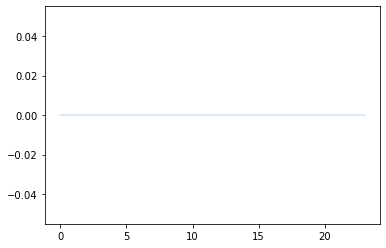

In [ ]:
dl.show()

In [ ]:
# TODO: adapt based on tabular core dataloader, add splits in 